Model: FCNet [2, 50, 50, 50, 50, 1]
Total Parameters: 7851

--- Starting ADAM Training ---
Epoch 1000: Loss = 6.14e+00 (Int: 1.87e+00, BC: 1.58e-03)
Epoch 2000: Loss = 7.66e+00 (Int: 1.15e+00, BC: 2.52e-03)
Epoch 3000: Loss = 1.50e+00 (Int: 6.82e-01, BC: 3.21e-04)
Epoch 4000: Loss = 1.39e+00 (Int: 4.58e-01, BC: 3.68e-04)
Epoch 5000: Loss = 1.35e+00 (Int: 3.49e-01, BC: 3.68e-04)
Epoch 6000: Loss = 1.14e+00 (Int: 2.47e-01, BC: 3.51e-04)
Epoch 7000: Loss = 7.86e-01 (Int: 1.83e-01, BC: 1.82e-04)
Epoch 8000: Loss = 5.80e-01 (Int: 1.29e-01, BC: 1.79e-04)
Epoch 9000: Loss = 9.65e-01 (Int: 1.13e-01, BC: 3.40e-04)
Epoch 10000: Loss = 7.47e-01 (Int: 8.25e-02, BC: 2.64e-04)

--- Starting LBFGS Optimization ---

Training completed in 314.15 seconds.
Final Loss: 7.30578e-04

RESULTS SUMMARY (Example 2)
Computation Time: 314.1515 seconds
Architecture: [2, 50, 50, 50, 50, 1]
----------------------------------------
ERRORS (Absolute | Relative)
L2 Error: 5.8579e-04  |  1.7226e-03
H1 Error: 4.0067e-03 

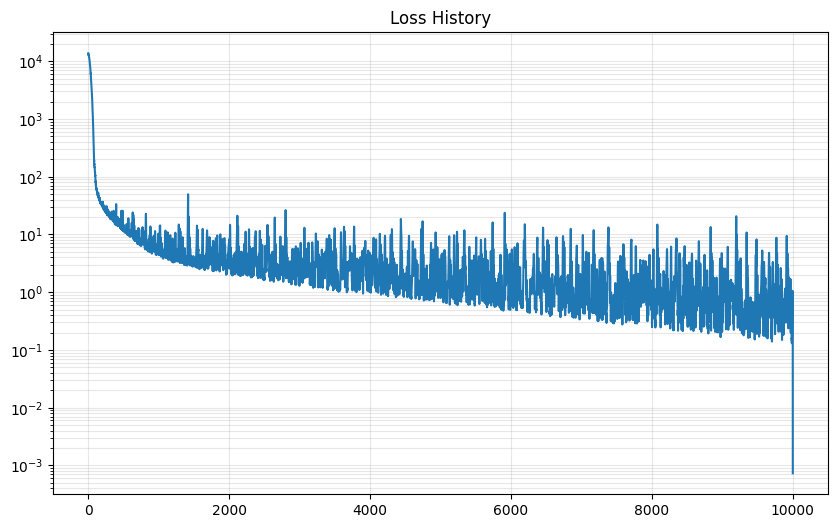

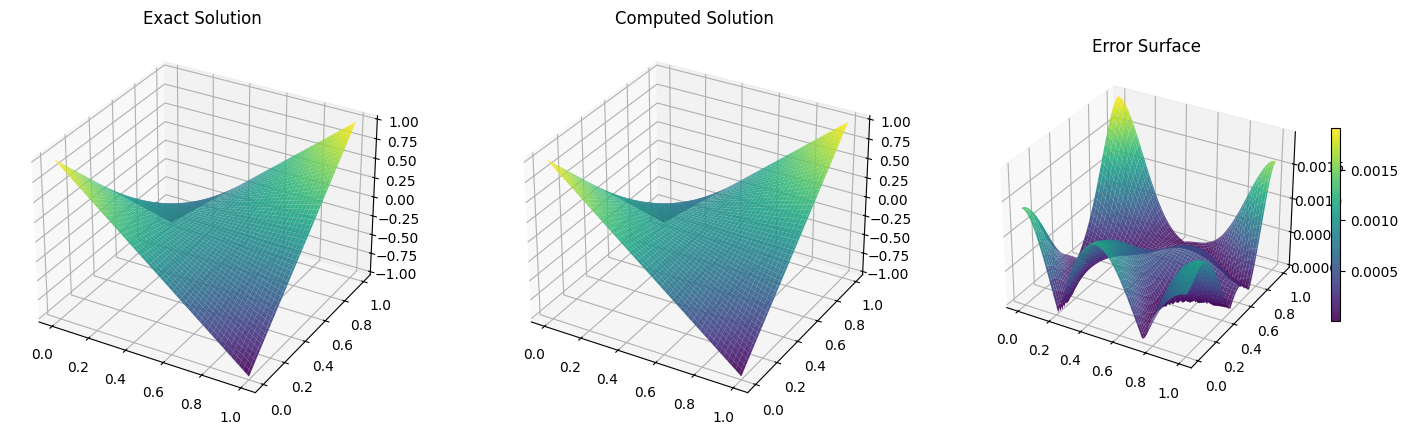

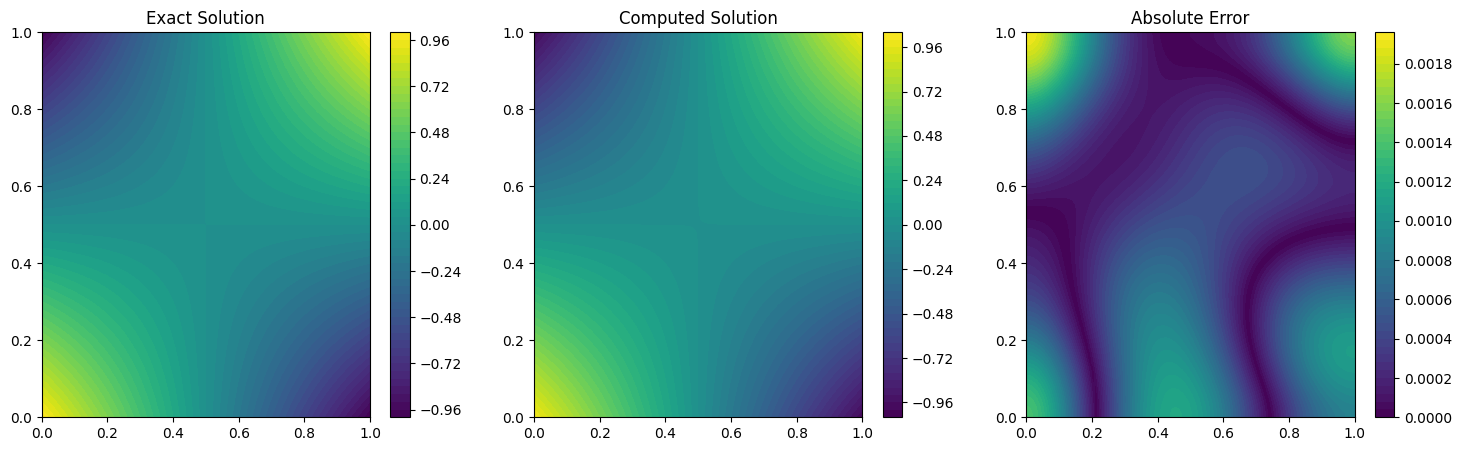

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

# -----------------------------------------------------------------------------
# 1. Configuration
# -----------------------------------------------------------------------------
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


LAYERS = [2, 50, 50, 50, 50, 1] 

EPOCHS_ADAM = 10000      
LR_ADAM = 1e-3
EPOCHS_LBFGS = 25000     

# Penalties (Tuned for Example 2)
LAMBDA_BC = 5000.0        
LAMBDA_MEAN = 500.0       # Zero-mean constraint (Critical for P4)

# Sampling
N_INTERIOR = 5000 
N_BOUNDARY = 1000

# -----------------------------------------------------------------------------
# 2. Neural Network (Flexible MLP)
# -----------------------------------------------------------------------------
class FCNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.activation = nn.Tanh() # Tanh is C^inf, good for derivatives
        
       
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            
            # Xavier Initialization (helps convergence)
            nn.init.xavier_normal_(self.layers[-1].weight)
            nn.init.zeros_(self.layers[-1].bias)

    def forward(self, x):
        out = x
        for i in range(len(self.layers) - 1):
            out = self.activation(self.layers[i](out))
        # Final layer (no activation)
        out = self.layers[-1](out)
        return out

# -----------------------------------------------------------------------------
# 3. Exact Solution & Helper Functions
# -----------------------------------------------------------------------------
def exact_u(x):
     """
    Example 2 : u = (2x - 1)(2y - 1)
    """
    return (2 * x[:, 0:1] - 1) * (2 * x[:, 1:2] - 1)

def source_f(x):
    """
    Source term f = Delta^2 u
    For u = (2x-1)(2y-1), Delta u = 0 => Delta^2 u = 0
    """
    return torch.zeros_like(x[:, 0:1])

def calc_laplacian(u, x):
    # First derivatives
    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x, u_y = grads[:, 0:1], grads[:, 1:2]
    
    # Second derivatives
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(u_y, x, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0][:, 1:2]
    return u_xx + u_yy, grads

def get_boundary_data(x_b, side):
    # u = (2x-1)(2y-1)
    x, y = x_b[:, 0:1], x_b[:, 1:2]
    ux = 2 * (2*y - 1)
    uy = 2 * (2*x - 1)
    
    # Normal derivatives
    if side == 'left':   du_dn = -ux
    elif side == 'right': du_dn = ux
    elif side == 'bottom': du_dn = -uy
    elif side == 'top':    du_dn = uy
    
    return du_dn # g1 (g2 is 0 for this problem)

# -------------------------------------------------------------------------
# 4. Loss Function
# -------------------------------------------------------------------------
def compute_loss(model, x_int, x_b_list):
    # Interior
    x_int.requires_grad = True
    u_int = model(x_int)
    lap_u, _ = calc_laplacian(u_int, x_int)
    
    # Energy: Integral[ 0.5*(Delta u)^2 - 0 ]
    interior_loss = torch.mean(0.5 * (lap_u ** 2))

    # Zero Mean Constraint
    mean_loss = (torch.mean(u_int)) ** 2
    
    # Boundary Penalty (Essential BC g1)
    bc_loss_penalty = 0
    sides = ['left', 'right', 'bottom', 'top']
    normals = [(-1,0), (1,0), (0,-1), (0,1)]
    
    for i, x_b in enumerate(x_b_list):
        x_b.requires_grad = True
        u_b = model(x_b)
        grads_b = torch.autograd.grad(u_b, x_b, torch.ones_like(u_b), create_graph=True, retain_graph=True)[0]
        nx, ny = normals[i]
        du_dn = grads_b[:, 0:1]*nx + grads_b[:, 1:2]*ny
        
        g1 = get_boundary_data(x_b, sides[i])
        bc_loss_penalty += torch.mean((du_dn - g1) ** 2)
        
    total_loss = interior_loss + LAMBDA_MEAN * mean_loss + (LAMBDA_BC/2) * bc_loss_penalty        # loss =   interior_energy+ λ_mean * mean_constraint  + λ_bc/2 * boundary_penalty 
    return total_loss, interior_loss, bc_loss_penalty

# -----------------------------------------------------------------------------
# 5. Training
# -----------------------------------------------------------------------------

# PRINT ARCHITECTURE + TOTAL NONZERO PARAMETERS
model = FCNet(LAYERS).to(DEVICE)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=LR_ADAM)

# Strict LBFGS 
optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(), 
    lr=1.0, 
    max_iter=EPOCHS_LBFGS, 
    max_eval=50000,
    tolerance_grad=1e-15, 
    tolerance_change=1e-15, 
    history_size=100, 
    line_search_fn="strong_wolfe"
)

loss_history = []

def get_batch():
    x_int = torch.rand(N_INTERIOR, 2).to(DEVICE)
    xb_list = [
        torch.cat([torch.zeros(N_BOUNDARY, 1), torch.rand(N_BOUNDARY, 1)], dim=1).to(DEVICE),
        torch.cat([torch.ones(N_BOUNDARY, 1), torch.rand(N_BOUNDARY, 1)], dim=1).to(DEVICE),
        torch.cat([torch.rand(N_BOUNDARY, 1), torch.zeros(N_BOUNDARY, 1)], dim=1).to(DEVICE),
        torch.cat([torch.rand(N_BOUNDARY, 1), torch.ones(N_BOUNDARY, 1)], dim=1).to(DEVICE)
    ]
    return x_int, xb_list

print(f"Model: FCNet {LAYERS}")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

start_time = time.time()

# --- ADAM ---
print("\n--- Starting ADAM Training ---")
for epoch in range(1, EPOCHS_ADAM + 1):
    optimizer_adam.zero_grad()
    x_int, xb_list = get_batch()
    loss, int_term, bc_term = compute_loss(model, x_int, xb_list)
    loss.backward()
    optimizer_adam.step()
    
    # RECORD LOSS HISTORY FOR SAVING AND PLOTTING
    loss_history.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.2e} (Int: {int_term.item():.2e}, BC: {bc_term.item():.2e})")

# --- LBFGS ---
print("\n--- Starting LBFGS Optimization ---")
x_int_fixed, xb_list_fixed = get_batch()

lbfgs_iter = 0
def closure():
    global lbfgs_iter
    optimizer_lbfgs.zero_grad()
    loss, int_term, bc_term = compute_loss(model, x_int_fixed, xb_list_fixed) 
    loss.backward()
    
    lbfgs_iter += 1
    if lbfgs_iter % 1000 == 0:
         print(f"LBFGS Iter {lbfgs_iter}: Loss = {loss.item():.2e} (Int: {int_term.item():.2e}, BC: {bc_term.item():.2e})")
    return loss

optimizer_lbfgs.step(closure)
final_loss = closure().item()
loss_history.append(final_loss)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds.")
print(f"Final Loss: {final_loss:.5e}")

# -----------------------------------------------------------------------------
# 6. Evaluation & Plotting (Viridis + Fixed H2)
# -----------------------------------------------------------------------------
def compute_errors_and_plot(model):
    n_grid = 100
    x = np.linspace(0, 1, n_grid)
    y = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(x, y)
    pts = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T, dtype=torch.float32).to(DEVICE)
    pts.requires_grad = True
    
    u_pred = model(pts)
    u_exact = exact_u(pts)
    
    lap_pred, grads_pred = calc_laplacian(u_pred, pts)
    _, grads_exact = calc_laplacian(u_exact, pts)
    
    # --- H2 Calculation :  SECOND DERIVATIVES OF PREDICTED SOLUTION---
    ux, uy = grads_pred[:, 0:1], grads_pred[:, 1:2]

    # Derivatives of ux = ∂u/∂x
    d_ux = torch.autograd.grad(ux, pts, torch.ones_like(ux), create_graph=False, retain_graph=True)[0]
    uxx, uxy = d_ux[:, 0:1], d_ux[:, 1:2]
    d_uy = torch.autograd.grad(uy, pts, torch.ones_like(uy), create_graph=False, retain_graph=False)[0]
    uyy = d_uy[:, 1:2]
    
    # --- H² CALCULATION : SECOND DERIVATIVES OF EXACT SOLUTION ---
    ex_ux, ex_uy = grads_exact[:, 0:1], grads_exact[:, 1:2]
    
    # Derivatives of exact ux
    d_ex_ux = torch.autograd.grad(ex_ux, pts, torch.ones_like(ex_ux), create_graph=False, retain_graph=True)[0]
    ex_uxx, ex_uxy = d_ex_ux[:, 0:1], d_ex_ux[:, 1:2]
    d_ex_uy = torch.autograd.grad(ex_uy, pts, torch.ones_like(ex_uy), create_graph=False, retain_graph=False)[0]
    ex_uyy = d_ex_uy[:, 1:2]

 # --- CONVERT TO NUMPY FOR ERROR NORMS ---
    u_p = u_pred.detach().cpu().numpy().flatten()
    u_e = u_exact.detach().cpu().numpy().flatten()
    
    l2_sq = np.mean((u_p - u_e)**2)
    h1_sq = l2_sq + np.mean(np.sum((grads_pred.detach().cpu().numpy() - grads_exact.detach().cpu().numpy())**2, axis=1))
    hess_diff = (uxx.detach().cpu().numpy() - ex_uxx.detach().cpu().numpy())**2 + \
                2*(uxy.detach().cpu().numpy() - ex_uxy.detach().cpu().numpy())**2 + \
                (uyy.detach().cpu().numpy() - ex_uyy.detach().cpu().numpy())**2
    h2_sq = h1_sq + np.mean(hess_diff)
    
    l2_err = np.sqrt(l2_sq)
    h1_err = np.sqrt(h1_sq)
    h2_err = np.sqrt(h2_sq)
    
    l2_norm = np.sqrt(np.mean(u_e**2))
    h1_norm = np.sqrt(np.mean(u_e**2) + np.mean(np.sum(grads_exact.detach().cpu().numpy()**2, axis=1)))
    ex_hess = ex_uxx.detach().cpu().numpy()**2 + 2*ex_uxy.detach().cpu().numpy()**2 + ex_uyy.detach().cpu().numpy()**2
    h2_norm = np.sqrt(h1_norm**2 + np.mean(ex_hess))

    print("\n" + "="*40)
    print("RESULTS SUMMARY (Example 2)")
    print("="*40)
    print(f"Computation Time: {training_time:.4f} seconds")
    print(f"Architecture: {LAYERS}")
    print("-" * 40)
    print("ERRORS (Absolute | Relative)")
    print(f"L2 Error: {l2_err:.4e}  |  {l2_err/l2_norm:.4e}")
    print(f"H1 Error: {h1_err:.4e}  |  {h1_err/h1_norm:.4e}")
    print(f"H2 Error: {h2_err:.4e}  |  {h2_err/h2_norm:.4e}")
    print("-" * 40)

    # --- PLOTTING (Viridis) ---
    U_pred = u_p.reshape(n_grid, n_grid)
    U_exact = u_e.reshape(n_grid, n_grid)
    Abs_Error = np.abs(U_pred - U_exact)
    
    # 1. Loss
    plt.figure(figsize=(10, 6))
    plt.semilogy(loss_history)
    plt.title("Loss History")
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

    # 2. 3D Plots
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(X, Y, U_exact, cmap='viridis', alpha=0.9)
    ax1.set_title("Exact Solution")
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax2.plot_surface(X, Y, U_pred, cmap='viridis', alpha=0.9)
    ax2.set_title("Computed Solution")
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    surf = ax3.plot_surface(X, Y, Abs_Error, cmap='viridis', alpha=0.9)
    ax3.set_title("Error Surface")
    fig.colorbar(surf, ax=ax3, shrink=0.5)
    plt.show()

    # 3. 2D Contours
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1, 3, 1)
    cp_ex = plt.contourf(X, Y, U_exact, levels=50, cmap='viridis')
    plt.colorbar(cp_ex)
    plt.title("Exact Solution")
    
    plt.subplot(1, 3, 2)
    cp = plt.contourf(X, Y, U_pred, levels=50, cmap='viridis') 
    plt.colorbar(cp)
    plt.title("Computed Solution")
    
    plt.subplot(1, 3, 3)
    cp_err = plt.contourf(X, Y, Abs_Error, levels=50, cmap='viridis') 
    plt.colorbar(cp_err)
    plt.title("Absolute Error")
    plt.show()

compute_errors_and_plot(model)